In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rand
import math 
import string as strin
matplotlib.style.use("ggplot")
%matplotlib inline

## **Testing random choice **

In [2]:
%%time
p = 0.4
N = 10**1
p= np.random.choice([1,0], N,p=[p, 1-p]).sum()/N
print(p)


0.5
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 472 µs


## testing average matrix from numpy

In [3]:
data = np.array([[0, 1],
       [2, 3],
       [4, 5]])
np.average(data, axis=0,weights=[1./4, 2./4, 1/4])

array([ 2.,  3.])

# Class for a single population

In [4]:
class population:
    def __init__(self, plist, N):
        self.plist = np.array(plist)
        self.N = N
        
        self.Rb = 1
        self.k = 20000
        self.rd = 10**(-3)
    
    def update(self):

        birth = int(self.N*self.Rb*(1 - self.N/self.k))

        if birth == 0: Birthplist = np.zeros(len(self.plist)); print('no birth')
        else:Birthplist = np.array([np.random.choice([1,0], birth,p=[pi, 1-pi]).sum()/birth for pi in self.plist])

        death = int(self.rd*self.N**2)
        survived = int(self.N - death)
        if survived == 0: Survivingplist = np.zeros(len(self.plist));print('ish')
        Survivingplist = np.array([np.random.choice([1,0], survived ,p=[pi, 1-pi]).sum()/survived for pi in self.plist])

        self.N += birth - death
        if self.N <= 0: print("dead pop")

        birthNSurvivedMatrix = np.array([Birthplist, Survivingplist ]) #self.plist
        self.plist = np.average(birthNSurvivedMatrix, axis = 0, weights=[birth/self.N,survived/self.N])
        

        
        
    def Hlist(self): return np.array([2*p*(1-p) for p in self.plist])
    def averageH(self): return self.Hlist().mean()
        

# One Population Simulation

In [5]:
plista = np.array([np.random.rand() for i in range(10)])
Na = 200
sidea = population(plista, Na)

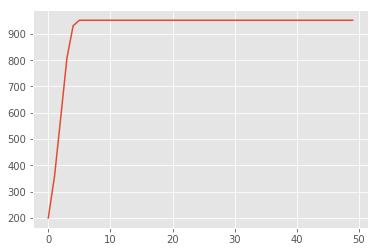

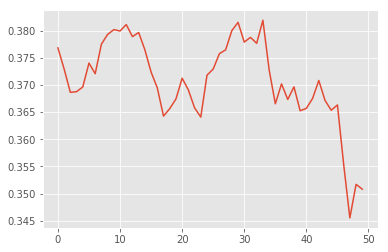

CPU times: user 516 ms, sys: 320 ms, total: 836 ms
Wall time: 516 ms


In [6]:
%%time
history = []
Hhistory = []
for i in range(50): 
    history += [sidea.N] 
    Hhistory += [sidea.averageH()]
    sidea.update()
    
plt.plot(history, label = "popsize");
plt.show()
plt.plot(Hhistory, label = 'H');
plt.show()


# Making class to Simulate migration

In [7]:
class wholePop:
    def __init__(self, populationA, populationB): 
        self.popa = populationA
        self.popb = populationB
        self.alphaA = .2
        self.alphaB = .2
        self.deathprob = .3
        self.nRoadsCrossedPerTimeUnit = 3
    def migrate(self):
        
        AtoB = self.alphaA*self.popa.N
        survivedAtoB = (1-self.deathprob)*AtoB
        BtoA = self.alphaB*self.popb.N
        survivedBtoA = (1- self.deathprob)*BtoA
        
        self.popa.plist = np.average([self.popa.plist, self.popb.plist], axis = 0 , weights = [self.popa.N-AtoB,survivedBtoA])
        self.popb.plist = np.average([self.popb.plist, self.popa.plist], axis = 0 , weights = [self.popb.N-BtoA,survivedAtoB])
        self.popa.N += survivedBtoA - AtoB
        self.popb.N += survivedAtoB - BtoA
        
        
        
    def update(self):
        self.popa.update() 
        self.popb.update()
        self.migrate()
        
    def FSTlist(self):
        PfreqMatrix = np.array([self.popa.plist, self.popb.plist])
        avgPFreq = np.average(PfreqMatrix, axis = 0 , weights = [.5,.5])
        expectedHlist = np.array([2*p*(1-p) for p in avgPFreq])
        
        HlistMatrixFromPops = np.array([self.popa.Hlist(), self.popb.Hlist()])
        ObservedHlistBothPops = np.average(HlistMatrixFromPops, axis = 0,  weights = [.5,.5])
        
        with np.errstate(divide='ignore', invalid='ignore'):
            subtraction = (expectedHlist - ObservedHlistBothPops)
            result = np.true_divide(subtraction,expectedHlist)
            result[result == np.inf] = 0
            result = np.nan_to_num(result)
        
        return result
    
    def FST(self): return self.FSTlist().mean()
        
        

# Adding another population

In [8]:
plist = np.array([np.random.rand() for i in range(10)])
Na = 500
sidea = population(plist, Na)
sideb = population(plist, Na)
bothsides = wholePop(sidea, sideb)


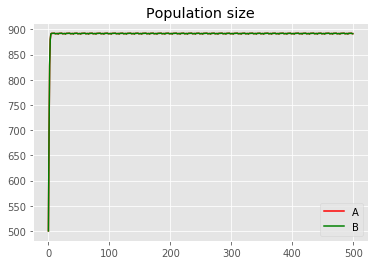

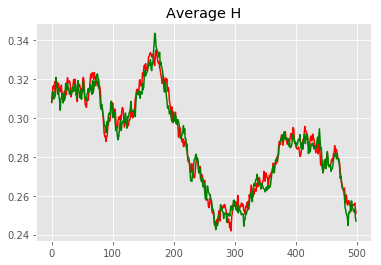

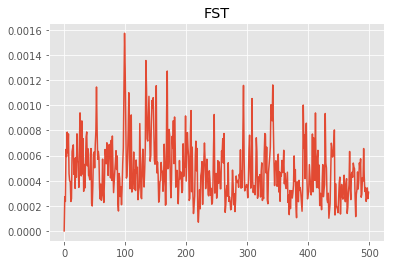

CPU times: user 1.69 s, sys: 564 ms, total: 2.25 s
Wall time: 1.63 s


In [9]:
%%time
historyA = []; historyB = []
HhistoryA = []; HhistoryB = []
FST_list = []
for i in range(500): 
    historyA += [bothsides.popa.N] 
    HhistoryA += [bothsides.popa.averageH()]
    historyB += [bothsides.popb.N] 
    HhistoryB += [bothsides.popb.averageH()]
    FST_list += [bothsides.FST()]
    bothsides.update()

    
plt.plot(historyA, label = "A", color = 'r');
plt.plot(historyB, label = "B", color = 'g');
plt.title("Population size")
plt.legend()
plt.show()
plt.plot(HhistoryA, label = 'A', color = 'r');
plt.plot(HhistoryB, label = 'B', color = 'g');
plt.title('Average H')
plt.show()
plt.plot(FST_list)
plt.title('FST')
plt.show()

## reset values
plist = np.array([np.random.rand() for i in range(10)])
Na = 100
sidea = population(plist, Na)
sideb = population(plist, Na)
bothsides = wholePop(sidea, sideb)

## FST heatmap altering migration and death

In [10]:
%%time
XD, M = 10, 10
heatmap = np.zeros((XD,M))
heatmap_pop = np.zeros((XD,M))
plist = np.array([np.random.rand() for i in range(50)])
Na = 500

for Dcounter, deathrateI in enumerate(np.linspace(0.05, .95 , XD)):
    for Mcounter, migrationI in enumerate(np.linspace(0.05, .52, M)):
        sidea = population(plist, Na)
        sideb = population(plist, Na)
        bothsides = wholePop(sidea, sideb)
        bothsides.deathprob = deathrateI
        bothsides.alphaA, bothsides.alphaB = migrationI, migrationI
        
        for i in range(500): bothsides.update()
        heatmap[Dcounter, Mcounter] = math.log10(bothsides.FST())
        heatmap_pop[Dcounter, Mcounter] = bothsides.popa.N + bothsides.popb.N
        
plt.imshow(heatmap, origin = 'lower')
plt.title('FST')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Migration')
plt.ylabel('Xing Death Prob')
plt.colorbar()
plt.savefig("heatmap", figsize= (10,10),  bbox_inches='tight', DPI = 300)
plt.show()
plt.close()

plt.imshow(heatmap_pop, origin = 'lower')
plt.title('Population Size')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Migration')
plt.ylabel('Xing Death Prob')
plt.colorbar()
plt.savefig("heatmap_pop", figsize= (10,10),  bbox_inches='tight', DPI = 300)
plt.show()
            
        
        

KeyboardInterrupt: 

# Infinite Allele Model 

In [11]:
class microsattelite:
    def __init__(self, initial_list, newNames = True):
        self.microsat = np.array(initial_list)
        self.mutation_rate = 10**(-2)
        self.initialAlleleCount = len(initial_list)
        self.s = strin.ascii_lowercase + strin.digits
        if newNames == True:
            self.satNames = ["ORI"+"".join([rand.choice(self.s) for k in range(3)]) for i in range(len(initial_list))]
        else: 
            self.satNames = newNames
        
    def Allele_count(self):
        return len(self.microsat)
        
    def New_mutation(self, N):
        if N <= 0: print('zero division here'); N= 1
        self.microsat*=((N-1)/N)
        self.microsat = np.append(self.microsat, [1/N])
        self.satNames += ["".join([rand.choice(self.s) for k in range(5)])]

    def number_of_mutation_that_occured(self, N, sigma): 
        return np.random.choice([1,0], N,p=[sigma, 1-sigma]).sum()
    
    
    #tested and working
    def sample_generator(self, Nsamples, rep = True):
        if Nsamples <= 0: print('major error here')
        probs  = np.array([max(0, i) for i in self.microsat])
        probs*= 1/probs.sum()
        new_list = np.zeros(self.Allele_count())
        alleleSamples = np.random.choice(self.Allele_count(), Nsamples ,p=probs, replace= rep)
        for i in alleleSamples: new_list[i] += 1
            
        return microsattelite(new_list/Nsamples, self.satNames)
    
    def Heterozygosity(self):
        return 1 - np.array([x**2 for x in self.microsat]).sum()
    
    def trim_null_microsats(self, N):
        result = []
        result_names =[]
        for position,value in enumerate(self.microsat):
            if value >= 10**(-math.log10(N)):
                result += [value]
                result_names += [self.satNames[position]]
        
        self.microsat = np.array(result)
        self.satNames = result_names
        
        #self.microsat = self.microsat[self.microsat > 10**(-math.log10(N))] 
        self.microsat *= 1/self.microsat.sum()
        
    def nonreplaceSampleGen(self, N_sample, N):

        new_list = np.zeros(self.Allele_count())
        FULLPOP = np.array([])
        for counter, alleleFreq in enumerate(self.microsat):
            FULLPOP =np.append(FULLPOP, np.full(int(N*alleleFreq), counter))
        SAMPLE = np.random.choice(FULLPOP, int(N_sample), replace = False)
        for i in SAMPLE: new_list[int(i)] += 1
        
        samplefreq = new_list/new_list.sum()
        
        return microsattelite(samplefreq, self.satNames)
           

            
    
def generate_random_microsatellite_list(size, nalleles):
    tempList = []
    for j in range(size):
        randomprobs = np.array([rand.random() for i in range(nalleles)])
        randomprobs *= 1/randomprobs.sum()
        tempList += [microsattelite(randomprobs)]
    return np.array(tempList)
    
        
#tested and working        
def weighted_avg_microsat(microsat1, n1, microsat2, n2):
    if n1+ n2<=0: print('error_avg microsat'); return 0
    avg = [(microsat1.microsat[i]*n1 + microsat2.microsat[i]*n2)/(n1+n2) for i in range(microsat1.Allele_count())]
    return microsattelite(np.array(avg), microsat1.satNames)

def migrated_microsat_freq(microsatTotal, ntotal, microsatstayed, nstayed): #funciona
    avg = [(microsatTotal.microsat[i]*ntotal - microsatstayed.microsat[i]*nstayed)/(ntotal-nstayed) for i in range(microsatTotal.Allele_count())]
    return microsattelite(np.array(avg), microsatTotal.satNames)

class population_IAM:
    def __init__(self, plist, N):
        self.microsatLIST = np.array(plist)
        self.N = N
        self.Rb = 1
        self.k = 20000
        self.mutationrate = 10**(-2.5)
        self.rd = 10**(-3)
            
    def update(self):

        birth = int(self.N*self.Rb*(1 - self.N/self.k))

        Birthsamples = np.array([eachmicrosat.sample_generator(birth) for eachmicrosat in self.microsatLIST])

        death = self.rd*self.N**2
        survived = int(self.N - death)
        if survived == 0: Survivingplist = np.zeros(len(self.plist));print('ish')
        
        Survivingsamples = np.array([eachmicrosat.nonreplaceSampleGen(survived,self.N) for eachmicrosat in self.microsatLIST])
        self.N = birth + survived
        if self.N <= 0: print("dead pop")

        self.microsatLIST = [weighted_avg_microsat(Birthsamples[i],birth, Survivingsamples[i], survived) for i in range(len(self.microsatLIST))]
        self.microsatLIST = np.array(self.microsatLIST)
        
        for eachsat in self.microsatLIST: 
            eachsat.trim_null_microsats(self.N)
            for i in range(eachsat.number_of_mutation_that_occured(birth, self.mutationrate)):  eachsat.New_mutation(self.N)
        
    def Hlist(self): return np.array([x.Heterozygosity() for x in self.microsatLIST])
    def averageH(self): return self.Hlist().mean()
        
        
        

testing weighted avg function and heterozygosity function

In [12]:
%%time
a = microsattelite([.5,.5, .0])
b = microsattelite([.3, .5, .0])
c =weighted_avg_microsat(a, 1000000, b,5)
print(c.microsat)
a.New_mutation(100)
print(a.microsat)
print(a.satNames)
print(a.satNames[0])
a.trim_null_microsats(1000)
print(a.microsat)
print(a.satNames)
print(a.nonreplaceSampleGen(499, 500).microsat )
d = migrated_microsat_freq(a, 100, b,9 )
print(d.microsat)


[ 0.499999  0.5       0.      ]
[ 0.495  0.495  0.     0.01 ]
['ORI33u', 'ORIwrk', 'ORIelx', 'fsatk']
ORI33u
[ 0.495  0.495  0.01 ]
['ORI33u', 'ORIwrk', 'fsatk']
[ 0.49498998  0.49498998  0.01002004]
[ 0.51428571  0.49450549  0.01098901]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.86 ms


testing sample generator function

In [13]:
%%time
a = microsattelite([.5,.5])
b = a.sample_generator(100)
print(b.microsat)



[ 0.47  0.53]
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1.53 ms


testing initial microsat generator

In [14]:
a = generate_random_microsatellite_list(3, 2)
print(a[2].microsat.sum())

1.0


## Testing a single population in the IAM model

[ 0.26569113  0.6214978   0.11281107]
['ORIt5a', 'ORIw5x', 'ORI2dn']


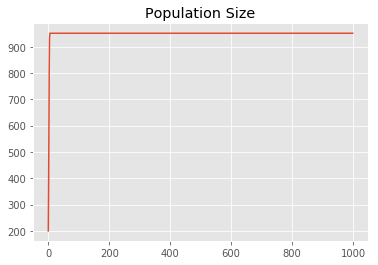

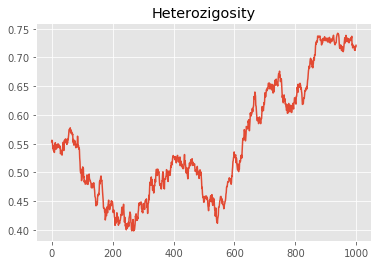

[10, 20, 11, 23, 9]
[ array([ 0.64705811,  0.07352933,  0.09873939,  0.12394944,  0.01995796,
        0.02836131,  0.00315126,  0.00210084,  0.00210084,  0.00105152])
 array([ 0.2723452 ,  0.12933768,  0.00841221,  0.01997899,  0.0851736 ,
        0.02944272,  0.15562583,  0.13880142,  0.00946373,  0.04206104,
        0.04837019,  0.03575188,  0.0042061 ,  0.00736068,  0.00315458,
        0.0042061 ,  0.00210305,  0.00210305,  0.00105042,  0.00105152])
 array([ 0.30874605,  0.44467861,  0.12012645,  0.02950474,  0.00842993,
        0.01159115,  0.00316122,  0.04214963,  0.02528978,  0.00210748,
        0.00421496])
 array([ 0.09309469,  0.21129358,  0.0533464 ,  0.03347225,  0.15899319,
        0.24476583,  0.02510419,  0.01673612,  0.00209202,  0.02510419,
        0.03661027,  0.06171446,  0.00836806,  0.00732205,  0.00941407,
        0.00209202,  0.00313802,  0.00209202,  0.00104711,  0.00104821,
        0.00104931,  0.00105042,  0.00105152])
 array([ 0.18067207,  0.48529358,  0.1281

In [15]:
%%time

sidea = population_IAM(generate_random_microsatellite_list(5, 3), 200)
print(sidea.microsatLIST[0].microsat)
print(sidea.microsatLIST[0].satNames)
history = []
Hhistory = []
for i in range(1000): 
    history += [sidea.N] 
    Hhistory += [sidea.averageH()]
    sidea.update()
    
plt.plot(history );
plt.title("Population Size")
plt.show()
plt.plot(Hhistory);
plt.title('Heterozigosity')
plt.show()
print([x.Allele_count() for x in sidea.microsatLIST])
print(np.array([sidea.microsatLIST[n].microsat for n in range(5)]))
print(np.array([sidea.microsatLIST[n].satNames for n in range(5)]))



# Making two populations with migration in the IAM model

In [16]:
def unify_alleles_avg(microsat1, n1, microsat2, n2): #tested and working 
    result = []
    alll = set(microsat1.satNames) | set(microsat2.satNames)
    for i in alll:
        if i in microsat1.satNames: firstpart = microsat1.microsat[microsat1.satNames.index(i)]*n1
        else: firstpart = 0
        if i in microsat2.satNames: secondpart = microsat2.microsat[microsat2.satNames.index(i)]*n2
        else: secondpart = 0
        result += [(firstpart + secondpart)/(n1+n2)]
    return microsattelite(np.array(result), list(alll))


class WholePop_IAM:
    def __init__(self, populationA, populationB): 
        self.popa = populationA
        self.popb = populationB
        self.alphaA = .02
        self.alphaB = .02
        self.deathprob = .9
        self.nRoadsCrossedPerTimeUnit = 3
        
        
    def migrate(self):
        
        AtoB = self.alphaA*self.popa.N
        survivedAtoB = (1-self.deathprob)*AtoB
        stayedAN = self.popa.N-AtoB

        
        stayedinAFreq = np.array([eachmicrosat.nonreplaceSampleGen(stayedAN,int(self.popa.N)) for eachmicrosat in self.popa.microsatLIST])
        AtoBfreq = np.array([migrated_microsat_freq(self.popa.microsatLIST[i],self.popa.N, stayedinAFreq[i], stayedAN) for i in range(len(self.popa.microsatLIST))])

                
        
        BtoA = self.alphaB*self.popb.N
        survivedBtoA = (1- self.deathprob)*BtoA
        stayedBN = int(self.popb.N-BtoA)
        
        stayedinBFreq = np.array([eachmicrosat.nonreplaceSampleGen(stayedBN ,int(self.popb.N)) for eachmicrosat in self.popb.microsatLIST])
        BtoAfreq = np.array([migrated_microsat_freq(self.popb.microsatLIST[i],self.popb.N, stayedinBFreq[i], stayedBN) for i in range(len(self.popb.microsatLIST))])
        
        self.popa.microsatLIST = [unify_alleles_avg(stayedinAFreq[i],stayedAN,BtoAfreq[i], survivedBtoA) for i in range(len(self.popa.microsatLIST))]
        self.popb.microsatLIST = [unify_alleles_avg(stayedinBFreq[i],stayedBN,AtoBfreq[i], survivedAtoB) for i in range(len(self.popb.microsatLIST))]
        
        self.popa.N += survivedBtoA - AtoB
        self.popb.N += survivedAtoB - BtoA
        
    def update(self):
        self.popa.update() 
        self.popb.update()
        self.migrate()
        
    def FSTlist(self):
        
        expectedFreqs = [unify_alleles_avg(self.popa.microsatLIST[i],self.popa.N,self.popb.microsatLIST[i],self.popb.N) for i in range(len(self.popa.microsatLIST))]

        global_pop = population_IAM(expectedFreqs, self.popa.N + self.popb.N)
        expectedHlist = global_pop.Hlist()
        
        HlistMatrixFromPops = np.array([self.popa.Hlist(), self.popb.Hlist()])
        ObservedHlistBothPops = np.average(HlistMatrixFromPops, axis = 0,  weights = [.5,.5])
        
        with np.errstate(divide='ignore', invalid='ignore'):
            subtraction = (expectedHlist - ObservedHlistBothPops)
            result = np.true_divide(subtraction,expectedHlist)
            result[result == np.inf] = 0
            result = np.nan_to_num(result)
        
        return result
    
    def FST(self): return self.FSTlist().mean()
        

In [17]:
plist = np.array([np.random.rand() for i in range(10)])
Na = 200
sidea = population_IAM(generate_random_microsatellite_list(5, 3), Na)
sideb = population_IAM(generate_random_microsatellite_list(5, 3), Na)

sideb = population_IAM(sidea.microsatLIST, Na)
bothsides = WholePop_IAM(sidea, sideb)
print(bothsides.popa.microsatLIST[0].microsat)

print(bothsides.popb.microsatLIST[0].microsat)



[ 0.23040802  0.36626311  0.40332887]
[ 0.23040802  0.36626311  0.40332887]


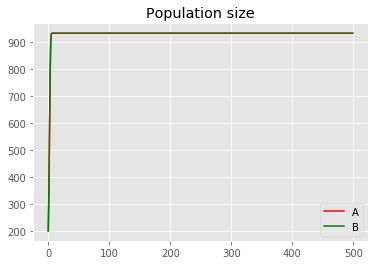

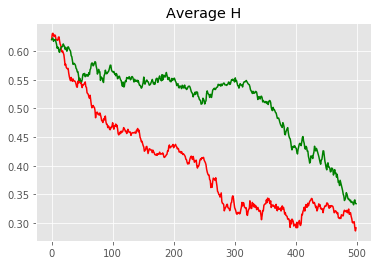

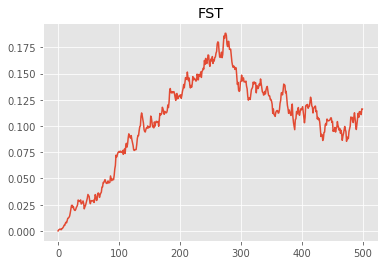

[ list(['ORIizk', 'k8q44', '8gt2v', '37fff', '5hptq', 'ORIfm3', '4o23u', 'cq7zs'])
 list(['ORIk1e', 'twb3p', 'q5bx9', 'ORIdk0', 'jmpa5'])
 list(['vxmoe', 'ORI84a', 'y9v1m', 'snc6o', 'ORIaas', 'b5xib', '1k1wk', '2yix7'])
 list(['ORIl9n', '7vkf3', '6fft6', 'z1eyg', 'ORIltc', 'axf8w', 'npqh6'])
 list(['ORI92c', 'hz9am', 'qkpfi', '9v21o', '66aci', 'ORIp09', 'lszcu', 'tmo4w', 'u8gw2', 'ORIqg6', 'mh6k5'])]
[ list(['k8q44', '8gt2v', '5hptq', 'cq7zs', '37fff', 'ORIfm3', '4o23u', 'ORIizk'])
 list(['jmpa5', 'ORIk1e', 'twb3p', 'ORIdk0', 'q5bx9'])
 list(['snc6o', 'ORI84a', 'ORIaas', 'b5xib', '1k1wk', '2yix7', 'vxmoe', 'y9v1m'])
 list(['npqh6', 'ORIl9n', '6fft6', 'ORIltc', '7vkf3', 'z1eyg', 'axf8w'])
 list(['ORI92c', 'hz9am', 'qkpfi', '9v21o', '66aci', 'ORIp09', 'u8gw2', 'lszcu', 'ORIqg6', 'mh6k5', 'tmo4w'])]
CPU times: user 9.29 s, sys: 468 ms, total: 9.76 s
Wall time: 9.23 s


In [18]:
%%time
historyA = []; historyB = []
HhistoryA = []; HhistoryB = []
FST_list = []
for i in range(500): 
    
    historyA += [bothsides.popa.N]
    HhistoryA += [bothsides.popa.averageH()]
    historyB += [bothsides.popb.N] 
    HhistoryB += [bothsides.popb.averageH()]
    FST_list += [bothsides.FST()]
    bothsides.update()

    
plt.plot(historyA, label = "A", color = 'r');
plt.plot(historyB, label = "B", color = 'g');
plt.title("Population size")
plt.legend()
plt.show()
plt.plot(HhistoryA, label = 'A', color = 'r');
plt.plot(HhistoryB, label = 'B', color = 'g');
plt.title('Average H')
plt.show()
plt.plot(FST_list)
plt.title('FST')
plt.show()

print(np.array([bothsides.popa.microsatLIST[n].satNames for n in range(5)]))
print(np.array([bothsides.popb.microsatLIST[n].satNames for n in range(5)]))


In [19]:
%%time
XD, M = 10, 10
heatmap = np.zeros((XD,M))
heatmap_pop = np.zeros((XD,M))
Na = 500

for Dcounter, deathrateI in enumerate(np.linspace(0.1, .8 , XD)):
    for Mcounter, migrationI in enumerate(np.linspace(0.1, .52, M)):
        sidea = population_IAM(generate_random_microsatellite_list(5, 3), Na)
        sideb = population_IAM(sidea.microsatLIST, Na)
        bothsides = WholePop_IAM(sidea, sideb)
        bothsides.deathprob = deathrateI
        bothsides.alphaA, bothsides.alphaB = migrationI, migrationI
        
        for i in range(500): bothsides.update()
        heatmap[Dcounter, Mcounter] = math.log10(bothsides.FST())
        heatmap_pop[Dcounter, Mcounter] = bothsides.popa.N + bothsides.popb.N
        
plt.imshow(heatmap, origin = 'lower')
plt.title('FST IAM model')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Migration')
plt.ylabel('Xing Death Prob')
plt.colorbar()
plt.savefig("heatmap_IAM", figsize= (10,10),  bbox_inches='tight', DPI = 300)
plt.show()
plt.close()

plt.imshow(heatmap_pop, origin = 'lower')
plt.title('Population Size IAM model')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Migration')
plt.ylabel('Xing Death Prob')
plt.colorbar()
plt.savefig("heatmap_popIAM", figsize= (10,10),  bbox_inches='tight', DPI = 300)
plt.show()
            
        
        

KeyboardInterrupt: 